### Fiona and Shapely 

Fiona for input and output
Shapely for making and manipulating geodata

https://macwright.org/2012/10/31/gis-with-python-shapely-fiona.html

In [36]:
# first lets read the csv
import csv
with open('C:\Users\esergios\Desktop\some.csv','rb') as f:
    reader = csv.DictReader(f)
    for row in reader:
        print row

{'lat': '41.88', 'lon': '-87.63', 'name': 'Chicago'}
{'lat': '39.101', 'lon': '-94.584', 'name': 'Kansas City'}


In [57]:
# lets import geometry from shapely
from shapely.geometry import Point

# we need to reopen the csv
with open('C:\Users\esergios\Desktop\some.csv','rb') as f:
    reader = csv.DictReader(f)
    for row in reader:
        point = Point(float(row['lon']), float(row['lat']))

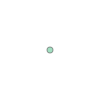

In [58]:
point

In [60]:
print mapping(point)

{'type': 'Point', 'coordinates': (-94.584, 39.101)}


In [61]:
# to save these points import fiona
import csv
from shapely.geometry import Point, mapping
from fiona import collection


schema = { 'properties': { 'name': 'str' } , 'geometry': 'Point', }


with collection("C:\Users\esergios\Desktop\points.shp", "w", "ESRI Shapefile", schema) as output:
    
    with open('C:\Users\esergios\Desktop\some.csv', 'rb') as f:
        reader = csv.DictReader(f)
        
        for row in reader:
            point = Point(float(row['lon']), float(row['lat']))
           
            output.write({
                'properties': {
                    'name': row['name']
                },
                'geometry': mapping(point)
            })


### Geopandas, Folium and Shapely 

Geopandas to read shapefiles, Fiona to plot them on a map and Shapely to give crs

In [116]:
import folium
import geopandas
%matplotlib inline

# read the shapefile
pnt_gdf = geopandas.GeoDataFrame.from_file(r'C:\Users\esergios\Desktop\points.shp') 

In [117]:
# check the geodataframe
pnt_gdf

,name,geometry
0,Chicago,POINT (-87.63 41.88)
1,Kansas City,POINT (-94.584 39.101)


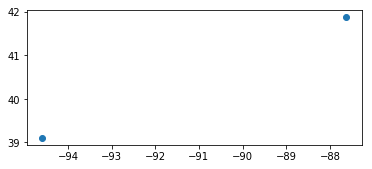

In [87]:
# plot them to check how they look like
pnt_gdf.plot()

In [118]:
# its time for the coordinate reference system because without we cant plot on leaflet
pnt_gdf.crs

{}

In [119]:
# import fionas crs and add it to the crs of the shapefile
from fiona.crs import to_string, from_string, from_epsg
pnt_gdf.crs = from_epsg(4326)
pnt_gdf.crs

{'init': 'epsg:4326', 'no_defs': True}

In [120]:
#Create SF basemap specifying map center, zoom level, and using the default OpenStreetMap tiles
mapa = folium.Map([40.606268, -91.040762], zoom_start = 7)
map_points= folium.features.GeoJson(pnt_gdf) # transforming the geodataframe into a json file to get read by leaflet
mapa.add_children(map_points)
mapa

C:\Program Files\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  after removing the cwd from sys.path.


### GIS operations 

buffer

In [146]:
from shapely.geometry import mapping, shape
from fiona import collection

with collection("C:\Users\esergios\Desktop\points.shp", "r") as input:

    schema = {'properties': { 'name': 'str' } , 'geometry': 'Polygon'}
    
    with collection(r"C:\Users\esergios\Desktop\_buffer_points.shp", "w", "ESRI Shapefile", schema) as output:
        
        for point in input:
            output.write({
                'properties': {
                    'name': point['properties']['name']
                },
                'geometry': mapping(shape(point['geometry']).buffer(5.0))
            })

In [147]:
# and check how do they look like
buf = geopandas.GeoDataFrame.from_file(r"C:\Users\esergios\Desktop\_buffer_points.shp") 
buf.crs = from_epsg(4326)
mapa = folium.Map([40.606268, -91.040762], zoom_start = 5)
buf_plgs= folium.features.GeoJson(buf) # transforming the geodataframe into a json file to get read by leaflet
mapa.add_children(buf_plgs)
mapa

C:\Program Files\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  


union

In [149]:
from shapely.geometry import mapping, shape
from shapely.ops import cascaded_union
from fiona import collection

with collection(r"C:\Users\esergios\Desktop\_buffer_points.shp", "r") as input:
    
    schema = input.schema.copy()
    
    with collection("C:\Users\esergios\Desktop\_buffer_points_union.shp", "w", "ESRI Shapefile", schema) as output:
        
        # create an empty list to add the shapes
        shapes = []
        
        for f in input:
            shapes.append(shape(f['geometry']))
        merged = cascaded_union(shapes)
        
        output.write({
            'properties': {
                'name': 'Buffer Area'
                },
            'geometry': mapping(merged)
            })

In [150]:
# and check how do they look like
buf_un = geopandas.GeoDataFrame.from_file("C:\Users\esergios\Desktop\_buffer_points_union.shp") 
buf_un.crs = from_epsg(4326)
mapa = folium.Map([40.606268, -91.040762], zoom_start = 5)
buf_un_plgs= folium.features.GeoJson(buf_un) # transforming the geodataframe into a json file to get read by leaflet
mapa.add_children(buf_un_plgs)
mapa

C:\Program Files\Anaconda2\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: Method `add_children` is deprecated. Please use `add_child` instead.
  
